In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
from tqdm import tqdm

### 1. Data Preprocessing

In [7]:
dataset = pd.read_csv(r"C:\Users\LOQ\important_features_dataset.csv")

In [8]:
X = dataset.drop('target_column', axis=1)
y = dataset['target_column']

In [9]:
print("Missing values in X:", X.isnull().sum().sum())
print("Missing values in y:", y.isnull().sum())

Missing values in X: 0
Missing values in y: 0


In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

### 2. Dataset Class

In [11]:
class URLDataset(Dataset):
    def __init__(self, features, labels, tokenizer, max_length=128):
        self.features = features.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        feature_str = ' '.join([f"{col}:{val}" for col, val in 
                              zip(self.features.columns, self.features.iloc[idx])])
        
        encoding = self.tokenizer.encode_plus(
            feature_str,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        }

### 3. splitting data

In [12]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

### 4. Tokenizer and Datasets

In [13]:
import warnings
warnings.filterwarnings("ignore")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=4  # 0: benign, 1: defacement, 2: phishing, 3: malware
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
train_dataset = URLDataset(X_train, y_train, tokenizer)
test_dataset = URLDataset(X_test, y_test, tokenizer)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [28]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### 5. Training BERT model

In [17]:
def train_model(model, train_loader, test_loader, epochs=5):
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    best_accuracy = 0
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_train_loss += loss.item()
            
            loss.backward()
            optimizer.step()
        
        # Evaluation
        model.eval()
        total_correct = 0
        total_samples = 0
        
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                
                predictions = torch.argmax(outputs.logits, dim=1)
                total_correct += (predictions == labels).sum().item()
                total_samples += labels.size(0)
        
        accuracy = total_correct / total_samples
        print(f'Epoch {epoch+1}:')
        print(f'Average training loss: {total_train_loss/len(train_loader):.4f}')
        print(f'Test accuracy: {accuracy:.4f}\n')
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'best_model.pt')

# Train the model
train_model(model, train_loader, test_loader)

Epoch 1/5: 100%|███████████████████████████████████████████████████████████████| 32559/32559 [1:59:33<00:00,  4.54it/s]


Epoch 1:
Average training loss: 0.2998
Test accuracy: 0.9079



Epoch 2/5: 100%|███████████████████████████████████████████████████████████████| 32559/32559 [1:56:23<00:00,  4.66it/s]


Epoch 2:
Average training loss: 0.2319
Test accuracy: 0.9173



Epoch 3/5: 100%|███████████████████████████████████████████████████████████████| 32559/32559 [1:59:11<00:00,  4.55it/s]


Epoch 3:
Average training loss: 0.2139
Test accuracy: 0.9213



Epoch 4/5: 100%|███████████████████████████████████████████████████████████████| 32559/32559 [1:53:52<00:00,  4.77it/s]


Epoch 4:
Average training loss: 0.2026
Test accuracy: 0.9248



Epoch 5/5: 100%|███████████████████████████████████████████████████████████████| 32559/32559 [1:57:11<00:00,  4.63it/s]


Epoch 5:
Average training loss: 0.1943
Test accuracy: 0.9248



### 6. Save the Model

In [18]:
# Save
model.save_pretrained('url_bert_model')
tokenizer.save_pretrained('url_bert_tokenizer')

('url_bert_tokenizer\\tokenizer_config.json',
 'url_bert_tokenizer\\special_tokens_map.json',
 'url_bert_tokenizer\\vocab.txt',
 'url_bert_tokenizer\\added_tokens.json')

In [30]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('url_bert_tokenizer')
model = BertForSequenceClassification.from_pretrained(
    'url_bert_model',
    num_labels=4
).to(device)

In [22]:
import json
# training info/metadata
training_info = {
    'num_classes': 4,
    'class_labels': ['benign', 'defacement', 'phishing', 'malware'],
    'max_length': 128,
    'epochs': 5,
    'batch_size': 16
}

with open('training_config.json', 'w') as f:
    json.dump(training_info, f)

### 7. Model evaluation

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [36]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

def evaluate_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in test_loader:
            outputs = model(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device)
            )
            
            probs = torch.softmax(outputs.logits, dim=1)
            predictions = torch.argmax(outputs.logits, dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels), np.array(all_probs)


def plot_metrics(predictions, labels, probabilities):
    class_names = ['benign', 'defacement', 'phishing', 'malware']
    
    report = classification_report(labels, predictions, target_names=class_names)
    print("Classification Report:")
    print(report)
    
    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ROC Curves
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(labels == i, probabilities[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.show()
    
    # Per-class accuracy
    print("\nPer-class Accuracy:")
    for i, class_name in enumerate(class_names):
        mask = labels == i
        accuracy = (predictions[mask] == labels[mask]).mean()
        print(f"{class_name} accuracy: {accuracy:.4f}")

In [34]:
# Load best model
import matplotlib.pyplot as plt

# model.load_state_dict(torch.load('best_model.pt'))
predictions, labels, probabilities = evaluate_model(model, test_loader, device)

Classification Report:
              precision    recall  f1-score   support

      benign       0.94      0.98      0.96     85621
  defacement       0.93      0.98      0.95     19291
    phishing       0.84      0.64      0.73     18819
     malware       0.95      0.89      0.92      6504

    accuracy                           0.92    130235
   macro avg       0.91      0.87      0.89    130235
weighted avg       0.92      0.92      0.92    130235



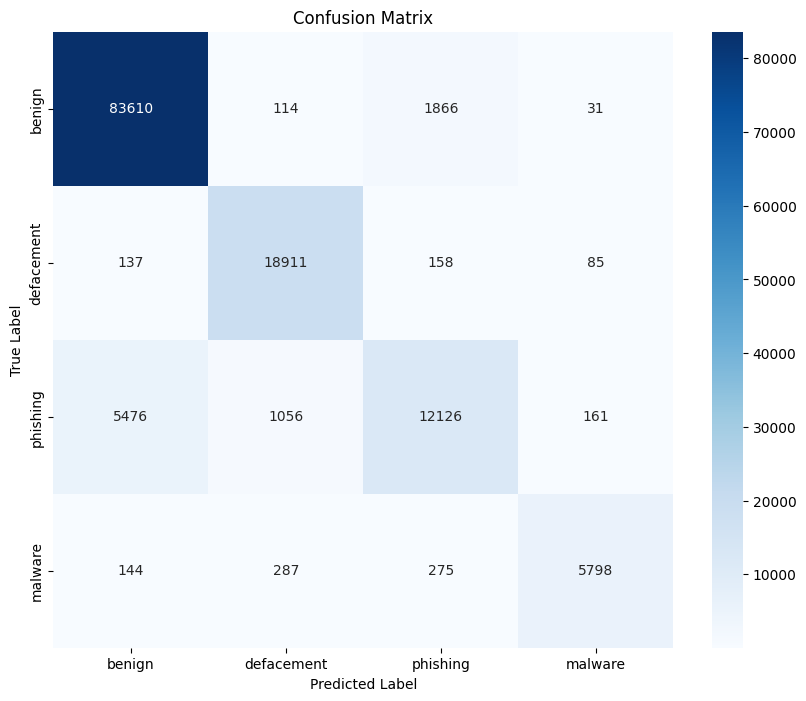

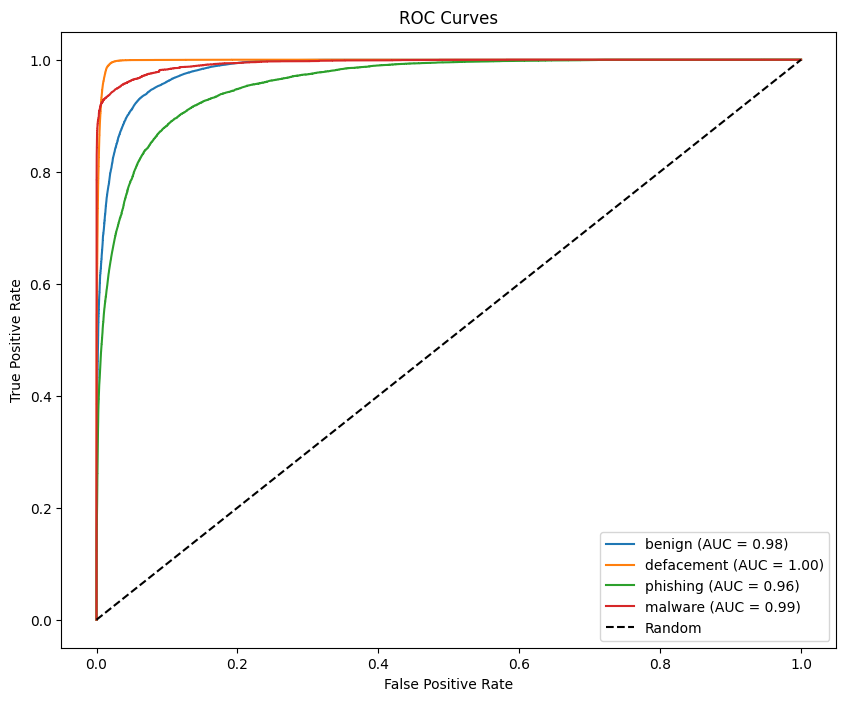


Per-class Accuracy:
benign accuracy: 0.9765
defacement accuracy: 0.9803
phishing accuracy: 0.6443
malware accuracy: 0.8915


In [38]:
import seaborn as sns

# Plot and print metrics
plot_metrics(predictions, labels, probabilities)

### 8. making prediction for single URL

In [43]:
import torch

def predict_single(features, model, tokenizer, device):
    # Define class names
    class_names = ['benign', 'defacement', 'phishing', 'malware']
    
    model.eval()
    feature_str = ' '.join([f"{col}:{val}" for col, val in features.items()])
        
    encoding = tokenizer.encode_plus(
        feature_str,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
        
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
        
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)
        prediction = torch.argmax(outputs.logits, dim=1)
        
    pred_class = prediction.item()
    pred_probs = probs[0].cpu().numpy()
    
    # Create prediction summary
    result = {
        'predicted_class': class_names[pred_class],
        'probabilities': dict(zip(class_names, pred_probs.round(3)))
    }
    
    return result

In [44]:
example_features = X_test.iloc[0]
prediction = predict_single(example_features, model, tokenizer, device)

In [45]:
print("\nExample Single Prediction:")
print(f"Predicted class: {prediction['predicted_class']}")
print("Class probabilities:", prediction['probabilities'])


Example Single Prediction:
Predicted class: defacement
Class probabilities: {'benign': 0.0, 'defacement': 0.996, 'phishing': 0.004, 'malware': 0.0}


=========================================================================================================